In this notebook, we train two SONAR-based toxicity classifiers, to illustrate two things:
- How a classification head on top of SONAR could be trained;
- How a SONAR encoder could be finetuned with some downstream task. 

The first model is adding a classifier layer on top of the frozen SONAR text encoder (like the [MuTox](https://aclanthology.org/2024.findings-acl.340/) model). The second is also unfreezing the encoder, allowing it to modify the underlying sentence representation to potentially better fit the task. 

In both cases, we will be using the unofficial HuggingFace port [cointegrated/SONAR_200_text_encoder](https://huggingface.co/cointegrated/SONAR_200_text_encoder) of the classifier, simply to avoid messing with fairseq2, in which original SONAR is implemented. 

We will be using two datasets for training and evaluation:
- MuTox (text transcriptions; the original dataset is speech-based)
    - see https://github.com/facebookresearch/seamless_communication/blob/main/src/seamless_communication/cli/toxicity/mutox/README.md
- Jigsaw toxic comments from three competitions:
    - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
    - https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
    - https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/data
    

Note: this notebook trains the models using 8 A100 GPUs. If you have other hardware configuration, consider adjusting the training parameters accordingly (e.g. reducing the batch size if it does not fit into GPU memory, or even downsampling the dataset). Please note that some kind of hardware accelerator is indispensable for running this training within reasonable time. If you do not have any, consider subscribing e.g. to Google Colab. 

The notebook does not depend on the [SONAR](https://github.com/facebookresearch/SONAR) codebase; instead, it depends only on HF [transformers](https://github.com/huggingface/transformers), HF [datasets](https://github.com/huggingface/datasets), and a bit of custom code.

**WARNING**: this notebook might contain examples of offensive or otherwise distubing texts in various languages. 



In [60]:
import pandas as pd
import torch
import datasets

from typing import Optional, Union
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer
from transformers.models.m2m_100.modeling_m2m_100 import M2M100Encoder, M2M100PreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import gc

Setting up some directories

In [1]:
DATA_DIR = "data"  # you will need to download the Jigsaw datasets there
MODELS_DIR = "models"  # the trained models will be saved there

# the two models will be saved here:
MODEL1_DIR = f"{MODELS_DIR}/SONAR_toxicity_classifier_frozen"
MODEL2_DIR = f"{MODELS_DIR}/SONAR_toxicity_classifier_unfozen"

Point to the model that we will fine-tune: https://huggingface.co/cointegrated/SONAR_200_text_encoder

In [2]:
BASE_MODEL_NAME = "cointegrated/SONAR_200_text_encoder"

Load the classifier in advance (we will need it while preparing the data). 

In [5]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

# 1. Compiling the datasets

## Mutox

The Mutox text dataset could be downloaded directly:

In [5]:
mutox_raw = pd.read_csv("https://dl.fbaipublicfiles.com/seamless/datasets/mutox.tsv", sep="\t")

In [6]:
mutox_raw.sample(3)

,id,lang,partition,public_url_segment,audio_file_transcript,contains_toxicity,toxicity_types,perlocutionary_effects,label,etox_result,detoxify_score,mutox_speech_score,mutox_text_score,mutox_zero_shot_speech_score,mutox_zero_shot_text_score
46427,fra_1181276,fra,train,http://www.archive.org/download/notredameparis...,"élas, mon frère, c'est que vous aviez bien rai...",No,NaN,NaN,0,NaN,0.001685,-24.469976,-28.979309,-12.300150,-18.465229
85753,41677.0,ell,train,https://bauernordic-pods.sharp-stream.com/gr/1...,Και φτάνεις σε ένα σημείο και λες δεν μπορώ ν...,No,NaN,NaN,0,NaN,0.768185,-8.917057,-18.839628,12.581656,-13.409579
57571,por_370751,por,devtest,https://feeds.soundcloud.com/stream/1121363227...,so para quando algm sangra ou cae no chãoae pa...,Yes,profanities,None of the above,1,merdas,0.976207,-0.573492,31.779409,-12.019632,-1.681559


Note that Mutox contains a certain portion of the texts that are missing or inadequately short; we would like to filter them out. 

In [20]:
print(mutox_raw['audio_file_transcript'].isnull().sum())
print((mutox_raw['audio_file_transcript'].str.len() < 5).sum())

3441
122


There are plenty of languages in the dataset: 

In [57]:
mutox_raw["partition"].value_counts()

partition
train      67971
dev        22273
devtest    10691
Name: count, dtype: int64

In [23]:
mutox_raw["lang"].value_counts()

lang
eng    17082
spa    17059
cat     2787
bul     2650
est     2631
ita     2615
hin     2601
arb     2560
por     2551
heb     2550
swh     2542
nld     2542
tgl     2527
ben     2526
ell     2526
dan     2525
fin     2524
vie     2523
fra     2523
tur     2520
rus     2519
slk     2518
urd     2517
pol     2515
deu     2514
cmn     2513
pes     2513
ces     2512
ind     2510
hun     2501
Name: count, dtype: int64

In [74]:
mutox_raw['contains_toxicity'].value_counts()

contains_toxicity
No            87887
Yes           13048
Cannot say     2623
Cannot Say     1927
yes              11
Name: count, dtype: int64

Cleaning the dataset and binarizing the label

In [77]:
mutox_cleaned = mutox_raw[
    mutox_raw['audio_file_transcript'].notnull()
    & mutox_raw['audio_file_transcript'].str.len().ge(5)
    & mutox_raw['contains_toxicity'].isin({'Yes', 'yes', 'No'})
].copy()
mutox_cleaned['toxic'] = mutox_cleaned['contains_toxicity'].apply({'Yes': 1, 'yes': 1, 'No': 0}.get)
print(mutox_raw.shape)
print(mutox_cleaned.shape)

(105496, 16)
(97509, 17)


## Jigsaw

For Jigsaw, you need to access the datasets manually. 

1. Please log into Kaggle, go to https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/data, and "download all" the data in to the `$DATA_DIR` directory (it is "data" for me, but you could use some directory elsewhere if you want). 
2. Unzip the data. 

On unix-like operation systems, the command to unzip them would go like this:

```
!cd $DATA_DIR && unzip jigsaw-multilingual-toxic-comment-classification.zip
```

The result will include the datasets from all three competitions. The directory contents could look as follows:

In [49]:
!ls $DATA_DIR

jigsaw-multilingual-toxic-comment-classification.zip
jigsaw-toxic-comment-train-processed-seqlen128.csv
jigsaw-toxic-comment-train.csv
jigsaw-unintended-bias-train-processed-seqlen128.csv
jigsaw-unintended-bias-train.csv
sample_submission.csv
test-processed-seqlen128.csv
test.csv
test_labels.csv
validation-processed-seqlen128.csv
validation.csv


Now we can read the datasets and add some missing columns:

In [50]:
jigsaw1_train = pd.read_csv(f"{DATA_DIR}/jigsaw-toxic-comment-train.csv")
jigsaw1_train.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
170768,2cb5cd297da37b3a,", but I don't know what DRV is, I'm afraid",0,0,0,0,0,0
123481,948a7ca2686cccde,By the way I will not appeal this block despit...,0,0,0,0,0,0
198711,9c0a4a0364eb1792,"In my opinion, it is impossible to explain wha...",0,0,0,0,0,0


In [51]:
jigsaw2_train = pd.read_csv(f"{DATA_DIR}/jigsaw-unintended-bias-train.csv")
jigsaw2_train.sample(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1225615,5612740,Why?,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,...,356357,approved,0,0,0,0,0,0.0,0,4
696078,4973759,"On the contrary, I believe EVERY new condo in ...",0.166667,0.166667,0.0,0.0,0.0,0.0,NaN,NaN,...,317444,approved,0,0,0,0,0,0.0,0,6
1136401,5504345,Money has ruined politics in this country. \n...,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,...,350258,approved,0,0,0,5,0,0.0,0,4


The unintended bias dataset has toxicity labels that are non-binary. We will convert them to binary by applying a threshold of 0.5.

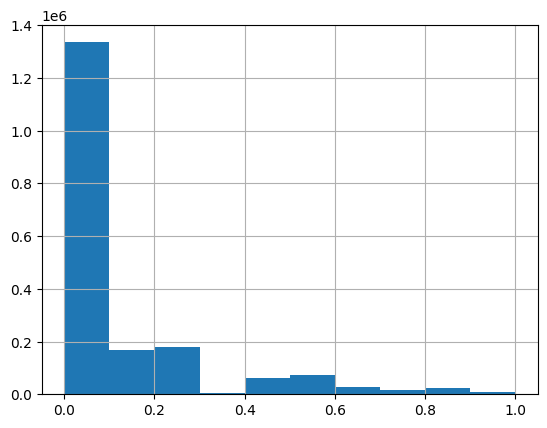

In [209]:
jigsaw2_train['toxic'].hist(bins=10);

In [215]:
jigsaw2_train['toxic_binary'] = jigsaw2_train['toxic'].gt(0.5).astype(int)

In [54]:
jigsaw3_valid = pd.read_csv(f"{DATA_DIR}/validation.csv")
jigsaw3_valid.sample(3)

,id,comment_text,lang,toxic
7502,7502,Sayın hocam sizden bir ricam daha olacak. Şu f...,tr,0
3607,3607,> Occhio tu piuttosto... con il rollback hai ...,it,0
2902,2902,È inutile che cercate di buttarla sul ridicolo...,it,1


In [53]:
jigsaw3_test = pd.read_csv(f"{DATA_DIR}/test.csv")
jigsaw3_test.sample(3)

,id,content,lang
6853,6853,"Valla hiç bir fikrim yok, bu akşam bir iki ker...",tr
16307,16307,"merhaba, Zeynel Limoncu maddesine yetersiz ve ...",tr
48448,48448,"Ненейтрально: Кабумба, Мбеки — министр Пропага...",ru


In [52]:
jigsaw3_test_labels = pd.read_csv(f"{DATA_DIR}/test_labels.csv")
jigsaw3_test_labels.sample(3)

,id,toxic
34608,34608,0
36778,36778,0
6329,6329,0


In [68]:
assert (jigsaw3_test['id'] == jigsaw3_test_labels['id']).all()
jigsaw3_test['toxic'] = jigsaw3_test_labels['toxic']

## Merge the datasets into one

In [69]:
jigsaw1_train['dataset'] = 'jigsaw1'
jigsaw2_train['dataset'] = 'jigsaw2'
jigsaw3_valid['dataset'] = 'jigsaw3'
jigsaw3_test['dataset'] = 'jigsaw3'

jigsaw1_train['split'] = 'train'
jigsaw2_train['split'] = 'train'
jigsaw3_valid['split'] = 'valid'
jigsaw3_test['split'] = 'test'

jigsaw1_train['lang'] = 'en'
jigsaw2_train['lang'] = 'en'

In [71]:
mutox_raw['dataset'] = 'mutox'
mutox_raw

In [229]:
data_pooled = pd.concat([
    jigsaw1_train.rename({'comment_text': 'text'}, axis=1), 
    jigsaw2_train[
        # removing the labels with low agreement between annotators
        jigsaw2_train['toxic'].lt(0.3) | jigsaw2_train['toxic'].gt(0.6)
    ].rename({'comment_text': 'text', 'toxic_binary': 'toxic', 'toxic': 'toxic_fraction'}, axis=1), 
    jigsaw3_valid.rename({'comment_text': 'text'}, axis=1), 
    jigsaw3_test.rename({'content': 'text'}, axis=1),
    mutox_cleaned.rename({'audio_file_transcript': 'text', 'partition': 'split'}, axis=1),
    
])[['text', 'toxic', 'lang', 'split', 'dataset']].dropna()

In [230]:
data_pooled.groupby(['dataset']).sample(3)

,text,toxic,lang,split,dataset
124242,Good idea and done. - ✉,0,en,train,jigsaw1
216946,""", 4 September 2011 (UTC) \n :::I'm adding to ...",0,en,train,jigsaw1
126160,tell your girl friend of your User:Nancy stop ...,0,en,train,jigsaw1
1575462,The numbers are stunning. This part of the co...,0,en,train,jigsaw2
1469311,So you agree that if two people in the househo...,0,en,train,jigsaw2
1537882,"They are fighting racism, especially state-spo...",0,en,train,jigsaw2
39046,"Дело не в этом, а в том, что простая подборка...",0,ru,test,jigsaw3
58817,45x45px|left Spam bağlantılar eklemeyi ...,0,tr,test,jigsaw3
22587,"Pardon pardon gerek kalmadı, zaten örneği verm...",0,tr,test,jigsaw3
7085,and the destruction of his dynasty.,0,eng,train,mutox


In each of the datasets, we have about 5-20% of toxic labels. 

In [231]:
data_pooled.groupby(['dataset', 'split'])['toxic'].aggregate(['count', 'mean'])

count      mean
dataset split                     
jigsaw1 train     223549  0.095657
jigsaw2 train    1699310  0.045574
jigsaw3 test       63812  0.225820
        valid       8000  0.153750
mutox   dev        22032  0.108932
        devtest    10308  0.135914
        train      65158  0.135532

## Map the language codes

SONAR model requires adding a special token indicating the language to the text being encoded.

So we need to re-format the language codes to agree with those of the SONAR tokenizer.

Here is an example of how the tokenizer works:

In [176]:
tokenizer.src_lang = "eng_Latn"  # setting the language that will be added to the text by default
tokens_ids = tokenizer('Hello world').input_ids
print(tokens_ids) # [256047, 94124, 15697, 2]
tokens = tokenizer.convert_ids_to_tokens(tokens_ids)
print(tokens)  # ['eng_Latn', '▁Hello', '▁world', '</s>']

[256047, 94124, 15697, 2]
['eng_Latn', '▁Hello', '▁world', '</s>']


In [112]:
lang_codes_map ={
    'arb': 'arb_Arab',
    'ben': 'ben_Beng',
    'bul': 'bul_Cyrl',
    'cat': 'cat_Latn',
    'ces': 'ces_Latn',
    'cmn': 'zho_Hans',
    'dan': 'dan_Latn',
    'deu': 'deu_Latn',
    'ell': 'ell_Grek',
    'en': 'eng_Latn',
    'eng': 'eng_Latn',
    'es': 'spa_Latn',
    'est': 'est_Latn',
    'fin': 'fin_Latn',
    'fr': 'fra_Latn',
    'fra': 'fra_Latn',
    'heb': 'heb_Hebr',
    'hin': 'hin_Deva',
    'hun': 'hun_Latn',
    'ind': 'ind_Latn',
    'it': 'ita_Latn',
    'ita': 'ita_Latn',
    'nld': 'nld_Latn',
    'pes': 'pes_Arab',
    'pol': 'pol_Latn',
    'por': 'por_Latn',
    'pt': 'por_Latn',
    'ru': 'rus_Cyrl',
    'rus': 'rus_Cyrl',
    'slk': 'slk_Latn',
    'spa': 'spa_Latn',
    'swh': 'swh_Latn',
    'tgl': 'tgl_Latn',
    'tr': 'tur_Latn',
    'tur': 'tur_Latn',
    'urd': 'urd_Arab',
    'vie': 'vie_Latn'
}

Check that we have covered all the languages in the dataset, and the codes are indeed part of the SONAR tokenizer:

In [239]:
data_pooled['lang_code'] = data_pooled['lang'].apply(lang_codes_map.get) 
assert data_pooled['lang_code'].isnull().sum() == 0

for lang_code in lang_codes_map.values():
    assert lang_code in tokenizer.special_tokens_map['additional_special_tokens']

# 2. Setting model architecture

We start by downloading the encoder from HuggingFace

In [8]:
encoder = M2M100Encoder.from_pretrained(BASE_MODEL_NAME)

In [9]:
encoder

M2M100Encoder(
  (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
  (embed_positions): M2M100SinusoidalPositionalEmbedding()
  (layers): ModuleList(
    (0-23): 24 x M2M100EncoderLayer(
      (self_attn): M2M100SdpaAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): ReLU()
      (fc1): Linear(in_features=1024, out_features=8192, bias=True)
      (fc2): Linear(in_features=8192, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In the spirit of the Hugginface typical models, we will add a classification head on top (just like, for example, [BertForSequenceClassification](https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py#L1472)).

In [10]:
class SonarForSequenceClassification(M2M100PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        
        self.sonar_encoder = M2M100Encoder(config)
        
        # the classifier will consist of a wide linear layer, non-linearity, dropout, and a final linear layer
        self.fc1 = nn.Linear(config.d_model, config.encoder_ffn_dim)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.encoder_ffn_dim, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()
        
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.sonar_encoder(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )
        token_embs = outputs.last_hidden_state
        sentence_embs = (token_embs * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.unsqueeze(-1).sum(1)
        
        hidden = self.fc1(sentence_embs)
        hidden = self.dropout(hidden)
        logits = self.classifier(hidden)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=sentence_embs,
        )

Create the model! And initialize its encoder by the actual SONAR encoder parameters.

In [11]:
encoder.config.num_labels = 2
encoder.config.problem_type = "single_label_classification"

model = SonarForSequenceClassification(encoder.config)

model.sonar_encoder.load_state_dict(encoder.state_dict())

<All keys matched successfully>

Here is how our model is supposed to classify:

In [12]:
sample_texts = ['Fuck you bitch!', 'Do you like dogs?', 'One more neutral sentence.']
tokenizer.src_lang = "eng_Latn"

with torch.inference_mode():
    out = model(**tokenizer(sample_texts, padding=True, return_tensors='pt').to(model.device))
    probabilities = torch.softmax(out.logits, dim=-1)
print(probabilities)

tensor([[0.5013, 0.4987],
        [0.5074, 0.4926],
        [0.4992, 0.5008]])


The outputs are a list of two-dimensional arrays, each of them containing probabilities of the labels. 

We have two-label classification as a problem, with the labels 0 (non-toxic) or 1 (toxic). Thus, the last column of the output (number 1, if we count from 0) contains the predicted probability of the texts being toxic. Which is by default close to 0.5 for all texts: before the training, the model doesn't know what to predict. 

# 3. Preparing the datasets for training

We want to use the Hugginface trainer, which expects the data to be pre-tokenized in advance. So we will do just that.

We will use all `train` and `dev` data for training, and `test` data for testing. We don't really need a validation dataset here, because we plan to train the models just once, without much hyperparameter tuning, so overfitting to the `test` split is not a problem.

In [251]:
ds_mix = datasets.DatasetDict({
    'train': datasets.Dataset.from_pandas(data_pooled[~data_pooled['split'].isin({'test', 'devtest'})], preserve_index=False),
    'test': datasets.Dataset.from_pandas(data_pooled[data_pooled['split'].isin({'test', 'devtest'})], preserve_index=False),
})
ds_mix

DatasetDict({
    train: Dataset({
        features: ['text', 'toxic', 'lang', 'split', 'dataset', 'lang_code'],
        num_rows: 2018049
    })
    test: Dataset({
        features: ['text', 'toxic', 'lang', 'split', 'dataset', 'lang_code'],
        num_rows: 74120
    })
})

The test split looks too big; we downsample it, taking at most 100 labels from each dataset-language-label combination. 

In [258]:
test_small = data_pooled[
    data_pooled['split'].isin({'test', 'devtest'})
].groupby(['dataset', 'lang_code', 'toxic']).apply(
    lambda x: x.sample(min(len(x), 100), random_state=1)
)
ds_mix['test_small'] = datasets.Dataset.from_pandas(test_small, preserve_index=False)
ds_mix

DatasetDict({
    train: Dataset({
        features: ['text', 'toxic', 'lang', 'split', 'dataset', 'lang_code'],
        num_rows: 2018049
    })
    test: Dataset({
        features: ['text', 'toxic', 'lang', 'split', 'dataset', 'lang_code'],
        num_rows: 74120
    })
    test_small: Dataset({
        features: ['text', 'toxic', 'lang', 'split', 'dataset', 'lang_code'],
        num_rows: 5101
    })
})

Now we can define the tokenization function (language-dependent!) and pre-tokenize the datasets.

In addition, we will rename the target to "labels"

In [247]:
def tokenize_function(examples, max_length=512):
    """ Tokenize the examples and prepend the right language tag."""
    result = tokenizer(
        text=list(examples["text"]),
        truncation=True,
        max_length=max_length,
    )
    lang_ids = tokenizer.convert_tokens_to_ids(list(examples["lang_code"]))
    for input_ids, lang_id in zip(result["input_ids"], lang_ids):
        input_ids[0] = lang_id

    if 'toxic' in examples:
        result['labels'] = examples['toxic']
    return result

print(tokenize_function({"text": ["Hi!", "Salut!", "Привет!"], "lang_code": ["eng_Latn", "fra_Latn", "rus_Cyrl"]}))

{'input_ids': [[256047, 2867, 248203, 2], [256057, 163119, 248203, 2], [256147, 12700, 9272, 248203, 2]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [259]:
ds_tokenized = ds_mix.map(tokenize_function, batched=True, batch_size=10_000, remove_columns=ds_mix['train'].column_names)

Map:   0%|          | 0/2018049 [00:00<?, ? examples/s]

Map:   0%|          | 0/74120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5101 [00:00<?, ? examples/s]

In [263]:
# save the dataset for reproducibility in the future
ds_tokenized.save_to_disk(f"{DATA_DIR}/tokenized_dataset")

Saving the dataset (0/2 shards):   0%|          | 0/2018049 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/74120 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5101 [00:00<?, ? examples/s]

# 4. Training a classifier with the frozen encoder

In [18]:
ds_tokenized = datasets.load_from_disk(f"{DATA_DIR}/tokenized_dataset")

To freeze the encoder, we will disable the gradient computation for all its parameters:

In [16]:
for param in model.sonar_encoder.parameters():
    param.requires_grad = False

Actually, it would be much faster to tokenize all the data in advance, and then to train only the head, feeding the embeddings directly to it. 

But I tried to make the code more generic, so I am treating a SONAR-based classifier as any other HF classifier. 

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

I will train the model for one epoch over the dataset (this should be sufficient to train the classifier head).

In [26]:
training_args = TrainingArguments(
    output_dir=MODEL1_DIR,
    num_train_epochs=1,
    logging_steps=500,
    save_steps=10_000,
    save_total_limit=50,
    per_device_train_batch_size=64, # for full-model training, this should be reduced to 16 or something like that
    warmup_steps=1_000,  # Adjust the number of the warmup steps to take about 10%-20% of the total number of steps per epoch.
    weight_decay=1e-3,
    optim="adamw_torch", # adafactor, if even with smaller batches you are out of memory 
    gradient_accumulation_steps=1,
    run_name='sonar-tox-trained-v1',
    learning_rate=1e-4,
    report_to="wandb", # turn this off if you don't have wandb
    # max_steps=100_000,
    bf16=True, # turn this off if your GPU doesn't support it
)

In [27]:
# Here is how many steps per epoch would be made with my setting (8 gpus):
print("steps per epoch", len(ds_tokenized['train']) / training_args.per_device_train_batch_size / 8)

steps per epoch 3941.501953125


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    data_collator=data_collator,
)

In [29]:
trainer.train()

/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.354900
1000,0.146400
1500,0.113300
2000,0.110100
2500,0.109200
3000,0.108100
3500,0.109500


/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 200}
  warnings.warn(


TrainOutput(global_step=3942, training_loss=0.14545092686731037, metrics={'train_runtime': 8355.0605, 'train_samples_per_second': 241.536, 'train_steps_per_second': 0.472, 'total_flos': 3.004701338322985e+18, 'train_loss': 0.14545092686731037, 'epoch': 1.0})

We can see that by the end of the epoch, the loss stagnates at the level about 0.1. Apparently, it cannot go much lower than that without unfreezing the model parameters. 

## Evaluating it

In [30]:
model.eval()

device(type='cuda', index=0)

In [33]:
preds1_small = trainer.predict(ds_tokenized['test_small'])

/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [42]:
with torch.inference_mode():
    p1_bad = torch.softmax(torch.tensor(preds1_small.predictions[0]), dim=-1)[:, 1].cpu().numpy()

In [49]:
print(roc_auc_score(preds1_small.label_ids, p1_bad))

0.8337834961877266


In [53]:
lang = [tokenizer.convert_ids_to_tokens(x['input_ids'][0]) for x in tqdm(ds_tokenized['test_small'])]

  0%|          | 0/5101 [00:00<?, ?it/s]

In [56]:
test_pred_df = pd.DataFrame({
    'label': preds1_small.label_ids,
    'pred': p1_bad,
    'lang': [tokenizer.convert_ids_to_tokens(x['input_ids'][0]) for x in tqdm(ds_tokenized['test_small'])],
})

  0%|          | 0/5101 [00:00<?, ?it/s]

In [59]:
test_pred_df.groupby('lang').apply(lambda x: roc_auc_score(x['label'], x['pred']))

lang
arb_Arab    0.887143
ben_Beng    0.820000
bul_Cyrl    0.820000
cat_Latn    0.911429
ces_Latn    0.880714
dan_Latn    0.858889
deu_Latn    0.806167
ell_Grek    0.842500
eng_Latn    0.676300
est_Latn    0.916552
fin_Latn    0.931034
fra_Latn    0.839628
heb_Hebr    0.858000
hin_Deva    0.780357
hun_Latn    0.884333
ind_Latn    0.740000
ita_Latn    0.801917
nld_Latn    0.703793
pes_Arab    0.911429
pol_Latn    0.874545
por_Latn    0.866679
rus_Cyrl    0.820039
slk_Latn    0.881333
spa_Latn    0.816425
swh_Latn    0.625667
tgl_Latn    0.688667
tur_Latn    0.885000
urd_Arab    0.845435
vie_Latn    0.838065
zho_Hans    0.732609
dtype: float64

# 5. Now unfeeze the model and train again

For unfrozen fine-tuning, we start with the current model - the one that has its classification head well trained. 

This way, we avoid the problem that the loss propagated from the randomly initialized head distorts the parameters of the underlying sentence encoder. 

In [71]:
# clean up some memory
trainer = None
gc.collect()
torch.cuda.empty_cache()

In [62]:
for param in model.sonar_encoder.parameters():
    param.requires_grad = True

In [75]:
training_args = TrainingArguments(
    output_dir=MODEL2_DIR,
    num_train_epochs=2,  # now with more parameters to train, we increase the number of epochs
    logging_steps=500,
    save_steps=5_000,
    save_total_limit=50,
    per_device_train_batch_size=32,
    warmup_steps=1_000,  # Adjust the number of the warmup steps to take about 10%-20% of the total number of steps per epoch.
    weight_decay=1e-3,
    optim="adafactor", # adafactor, if even with smaller batches you are out of memory 
    gradient_accumulation_steps=1,
    run_name='sonar-tox-trained-v2',
    learning_rate=1e-4,
    report_to="wandb", # turn this off if you don't have wandb
    # max_steps=100_000,
    bf16=True, # turn this off if your GPU doesn't support it
)

In [76]:
# Here is how many steps per epoch would be made with my setting (8 gpus):
print("steps per epoch", len(ds_tokenized['train']) / training_args.per_device_train_batch_size / 8)

steps per epoch 7883.00390625


In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    data_collator=data_collator,
)

We can see that the loss starts at the 0.095 level - slightly 

In [78]:
trainer.train()

/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.095400
1000,0.083500
1500,0.075400
2000,0.069800
2500,0.065700
3000,0.064500
3500,0.062000
4000,0.059500
4500,0.060500
5000,0.059000


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 200}
  warnings.warn(
/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along 

TrainOutput(global_step=15768, training_loss=0.05560727533140139, metrics={'train_runtime': 44037.4041, 'train_samples_per_second': 91.652, 'train_steps_per_second': 0.358, 'total_flos': 5.37354496011832e+18, 'train_loss': 0.05560727533140139, 'epoch': 2.0})

## Evaluating

In [79]:
model.eval()

1

In [80]:
preds2_small = trainer.predict(ds_tokenized['test_small'])

/home/daviddale/.conda/envs/fs2v04/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [81]:
with torch.inference_mode():
    p2_bad = torch.softmax(torch.tensor(preds2_small.predictions[0]), dim=-1)[:, 1].cpu().numpy()
print(roc_auc_score(preds2_small.label_ids, p2_bad))

0.8961500666222518


In [83]:
test_pred2_df = pd.DataFrame({
    'label': preds2_small.label_ids,
    'pred': p2_bad,
    'lang': [tokenizer.convert_ids_to_tokens(x['input_ids'][0]) for x in tqdm(ds_tokenized['test_small'])],
})

  0%|          | 0/5101 [00:00<?, ?it/s]

In [84]:
test_pred_df.groupby('lang').apply(lambda x: roc_auc_score(x['label'], x['pred']))

lang
arb_Arab    0.887143
ben_Beng    0.820000
bul_Cyrl    0.820000
cat_Latn    0.911429
ces_Latn    0.880714
dan_Latn    0.858889
deu_Latn    0.806167
ell_Grek    0.842500
eng_Latn    0.676300
est_Latn    0.916552
fin_Latn    0.931034
fra_Latn    0.839628
heb_Hebr    0.858000
hin_Deva    0.780357
hun_Latn    0.884333
ind_Latn    0.740000
ita_Latn    0.801917
nld_Latn    0.703793
pes_Arab    0.911429
pol_Latn    0.874545
por_Latn    0.866679
rus_Cyrl    0.820039
slk_Latn    0.881333
spa_Latn    0.816425
swh_Latn    0.625667
tgl_Latn    0.688667
tur_Latn    0.885000
urd_Arab    0.845435
vie_Latn    0.838065
zho_Hans    0.732609
dtype: float64

How does it work with our toy sentences?

We can see that the model is rather confidently predicting the first one as toxic, and the other two as neutral. 

In [87]:
sample_texts = ['Fuck you bitch!', 'Do you like dogs?', 'One more neutral sentence.']
tokenizer.src_lang = "eng_Latn"

with torch.inference_mode():
    out = model(**tokenizer(sample_texts, padding=True, return_tensors='pt').to(model.device))
    probabilities = torch.softmax(out.logits, dim=-1).cpu().numpy()
print(probabilities)

[[2.0675792e-04 9.9979323e-01]
 [9.9986959e-01 1.3042087e-04]
 [9.9996281e-01 3.7189438e-05]]


# Packaging

Here we show how to load the model from a directory. 

It has been already saved there by the trainer, but we'll also save the tokenizer, just for convenience.

In [89]:
gc.collect()
torch.cuda.empty_cache()

In [90]:
tokenizer.save_pretrained(f"{MODEL1_DIR}/checkpoint-3942")
tokenizer.save_pretrained(f"{MODEL2_DIR}/checkpoint-15768")

('models/SONAR_toxicity_classifier_unfozen/checkpoint-15768/tokenizer_config.json',
 'models/SONAR_toxicity_classifier_unfozen/checkpoint-15768/special_tokens_map.json',
 'models/SONAR_toxicity_classifier_unfozen/checkpoint-15768/sentencepiece.bpe.model',
 'models/SONAR_toxicity_classifier_unfozen/checkpoint-15768/added_tokens.json',
 'models/SONAR_toxicity_classifier_unfozen/checkpoint-15768/tokenizer.json')

In [91]:
!ls -alsh $MODEL2_DIR/checkpoint-15768

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 3.0G
   0 drwxrwxr-x 2 daviddale daviddale    0 Jul 28 14:26 .
   0 drwxrwxr-x 6 daviddale daviddale    0 Jul 28 11:14 ..
1.0K -rw-rw-r-- 1 daviddale daviddale  910 Jul 28 11:14 config.json
2.9G -rw-rw-r-- 1 daviddale daviddale 2.9G Jul 28 11:14 model.safetensors
5.4M -rw-rw-r-- 1 daviddale daviddale 5.4M Jul 28 11:14 optimizer.pt
 14K -rw-rw-r-- 1 daviddale daviddale  14K Jul 28 11:14 rng_state.pth
1.5K -rw-rw-r-- 1 daviddale daviddale 1.1K Jul 28 11:14 scheduler.pt
4.7M -rw-rw-r-- 1 daviddale daviddale 4.7M Jul 28 14:26 sentencepiece.bpe.model
4.5K -rw-rw-r-- 1 daviddale daviddale 4.2K Jul 28 14:26 special_tokens_map.json
 39K -rw-rw-r-- 1 daviddale daviddale  39K Jul 28 14:26 tokenizer_config.json
 31M -rw-rw-r-- 1 daviddale daviddale  31M Jul 28 14:26 tokenizer.json
6.0K -rw-rw-r-- 1 daviddale daviddale 6.0K Jul 28 11:14 trainer_state.json
5.5K -rw-rw-r-- 1 daviddale daviddale 5.3K Jul 28 11:14 training_args.bin


Now, let's load the new model and tokenizer!

In [92]:
new_model_dir = f"{MODEL2_DIR}/checkpoint-15768"

model2 = SonarForSequenceClassification.from_pretrained(new_model_dir)
tokenizer2 = AutoTokenizer.from_pretrained(new_model_dir)

Checking that the model gets exactly the same predictions as before:

In [93]:
sample_texts = ['Fuck you bitch!', 'Do you like dogs?', 'One more neutral sentence.']
tokenizer2.src_lang = "eng_Latn"

with torch.inference_mode():
    out = model2(**tokenizer2(sample_texts, padding=True, return_tensors='pt').to(model2.device))
    probabilities = torch.softmax(out.logits, dim=-1).cpu().numpy()
print(probabilities)

[[2.0675754e-04 9.9979323e-01]
 [9.9986959e-01 1.3042087e-04]
 [9.9996281e-01 3.7189402e-05]]
